# Assignment 1: Performance Analysis on a Quad-Core CPU

## Program 1: Parallel Fractal Generation Using Threads

Perform analysis, `--view 1`, `--view 2` respectively.

```bash
#!/usr/bin/env bash

for numThreads in {1..24} 
do
  echo -n "$numThreads: "
  ./mandelbrot -t $numThreads \
    | rg -o '\d+\.\d+x'
done
```

In [7]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt

In [8]:
x = np.arange(1, 25)
y_v1, y_v2 = None, None
y_ref = x

with open('prog1_mandelbrot_threads/prog1_res_1_view_1.txt', 'r') as f:
  lines = f.readlines()
  y_v1 = np.array([float(i.split()[1][:-1]) for i in lines])

with open('prog1_mandelbrot_threads/prog1_res_1_view_2.txt', 'r') as f:
  lines = f.readlines()
  y_v2 = np.array([float(i.split()[1][:-1]) for i in lines])

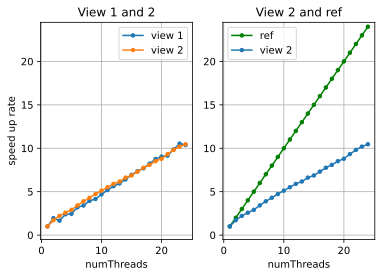

In [9]:
plt.subplot(1, 2, 1)
plt.plot(x, y_v1, marker='o', label='view 1', markersize = '3.5')
plt.plot(x, y_v2, marker='o', label='view 2', markersize = '3.5')
plt.title('View 1 and 2')
plt.grid(True)
plt.legend()
plt.ylim((-0.5, 24.5))
plt.xlabel('numThreads')
plt.ylabel('speed up rate')

plt.subplot(1, 2, 2)
plt.plot(x, y_ref, marker='o', label='ref', markersize = '3.5', color='green')
plt.plot(x, y_v2, marker='o', label='view 2', markersize = '3.5')
plt.title('View 2 and ref')
plt.grid(True)
plt.legend()
plt.ylim((-0.5, 24.5))
plt.xlabel('numThreads')

plt.show()

The critical point here is the left figure, when `numThreads = 3`, there's a sudden performance drop for view 1.

In our first experiment, we might expect that the performance improvement is likely to be
$$
  c = \texttt{numThreads} / 2
$$
where hyperthreading did nothing. But the result is actually linear.

If we export the running time in each thread, we might find that 
there's a large bias on each:
```txt
thread id: 2
    TPS: 3699999888.982327
    duration: [53.595272] ms
thread id: 0
    TPS: 3699999888.982327
    duration: [56.241852] ms
thread id: 1
    TPS: 3699999888.982327
    duration: [171.062695] ms
```

The working time for `threadId = 1` is much longer.

In [10]:
N = 32
x = np.arange(1, N + 1)
y_ref = x
y2_v1, y2_v2 = None, None

with open('prog1_mandelbrot_threads/prog1_res_2_view_1.txt', 'r') as f:
  lines = f.readlines()
  y2_v1 = np.array([float(i.split()[1][:-1]) for i in lines])

with open('prog1_mandelbrot_threads/prog1_res_2_view_2.txt', 'r') as f:
  lines = f.readlines()
  y2_v2 = np.array([float(i.split()[1][:-1]) for i in lines])

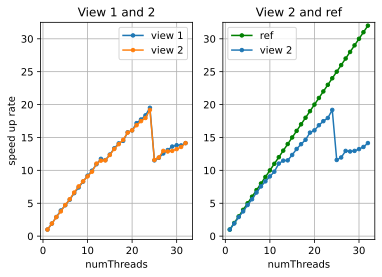

In [11]:
plt.subplot(1, 2, 1)
plt.plot(x, y2_v1, marker='o', label='view 1', markersize = '3.5')
plt.plot(x, y2_v2, marker='o', label='view 2', markersize = '3.5')
plt.title('View 1 and 2')
plt.grid(True)
plt.legend()
plt.ylim((-0.5, N + 0.5))
plt.xlabel('numThreads')
plt.ylabel('speed up rate')

plt.subplot(1, 2, 2)
plt.plot(x, y_ref, marker='o', label='ref', markersize = '3.5', color='green')
plt.plot(x, y2_v2, marker='o', label='view 2', markersize = '3.5')
plt.title('View 2 and ref')
plt.grid(True)
plt.legend()
plt.ylim((-0.5, N + 0.5))
plt.xlabel('numThreads')

plt.show()

Wow! The modification significantly promoted the performance.

Let's enable the per thread measurement again to observe more information.

```text
thread id: 1
    TPS: 3699999888.982327
    duration: [95.557163] ms
thread id: 2
    TPS: 3699999888.982327
    duration: [95.675083] ms
thread id: 0
    TPS: 3699999888.982327
    duration: [95.710363] ms
```

The result is rather interesting, and the intuitive explain is that we need to let the threads do similar things:
**similar operations, similar data**, which can make full use of our performance.

The three threads are slower, but their are identical.

## Program 3, Part 2: ISPC Tasks (10 of 20 points)

I use this bash script to modify the `nTasks`.

```bash
#!/usr/bin/env bash

for numTasks in {1..64} 
do
  echo -n "uniform int nTasks = $numTasks;" > ntasks.config.in
  make clean > /dev/null 2>&1
  make -j > /dev/null 2>&1
  make -j > /dev/null 2>&1
  echo -n "$numTasks: "
  ./mandelbrot_ispc -v 2 -t \
    | rg -o '\d+\.\d+x.+task' | awk '{ print $1 }'
done
```

In [25]:
y_ispc_1, y_ispc_2 = None, None;
with open('prog3_mandelbrot_ispc/prog3_res_1_view_1.txt', 'r') as f:
  lines = f.readlines()
  N = len(lines)
  x = np.arange(1, N + 1)
  y_ispc_1 = np.array([float(i.split()[1][:-1]) for i in lines])

with open('prog3_mandelbrot_ispc/prog3_res_1_view_2.txt', 'r') as f:
  lines = f.readlines()
  assert(N == len(lines))
  y_ispc_2 = np.array([float(i.split()[1][:-1]) for i in lines])

Text(0, 0.5, 'speed up rate')

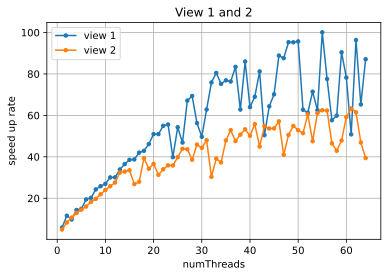

In [26]:
plt.plot(x, y_ispc_1, marker='o', label='view 1', markersize = '3.5')
plt.plot(x, y_ispc_2, marker='o', label='view 2', markersize = '3.5')
plt.title('View 1 and 2')
plt.grid(True)
plt.legend()
plt.xlabel('numThreads')
plt.ylabel('speed up rate')